In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from exif import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
BASE_DATA_PATH = '../data/raw/OCT2017/'
TRAIN_BASE_PATH = '../data/raw/OCT2017/train/'
TEST_BASE_PATH = '../data/raw/OCT2017/test/'

## Create Base Data

Write a program which imports all the metadata about the OCT files as a Pandas DataFrame

In [3]:
parents = ['train', 'test']
children = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# create a base dataframe from the directory items
names_cache = []
for p in parents:
    for c in children:
        files = os.listdir(os.path.join(BASE_DATA_PATH, p, c))
        instance_type = [ p for i in range(len(files)) ]
        path = [ f'/OCT2017/{p}/{c}' for i in range(len(files))]
        print(f'{p}/{c} contains {len(files)} files')
        names_cache.extend(list(zip(files, path, instance_type)))

oct_df = pd.DataFrame(names_cache, columns=['filename', 'path', 'type'])

# split filename into features
oct_df['disease'] = oct_df['filename'].apply(lambda f: f.split('-')[0])
oct_df['pat_id'] = oct_df['filename'].apply(lambda f: f.split('-')[1])
oct_df['img_id'] = oct_df['filename'].apply(lambda f: f.split('-')[2].split('.')[0])
oct_df['filetype'] = oct_df['filename'].apply(lambda f: f.split('.')[1])
oct_df

train/CNV contains 37205 files
train/DME contains 11348 files
train/DRUSEN contains 8616 files
train/NORMAL contains 26315 files
test/CNV contains 250 files
test/DME contains 250 files
test/DRUSEN contains 250 files
test/NORMAL contains 250 files


,filename,path,type,disease,pat_id,img_id,filetype
0,CNV-5557306-155.jpeg,/OCT2017/train/CNV,train,CNV,5557306,155,jpeg
1,CNV-163081-153.jpeg,/OCT2017/train/CNV,train,CNV,163081,153,jpeg
2,CNV-3537912-28.jpeg,/OCT2017/train/CNV,train,CNV,3537912,28,jpeg
3,CNV-7159021-147.jpeg,/OCT2017/train/CNV,train,CNV,7159021,147,jpeg
4,CNV-8087608-23.jpeg,/OCT2017/train/CNV,train,CNV,8087608,23,jpeg
...,...,...,...,...,...,...,...
84479,NORMAL-5246808-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,5246808,1,jpeg
84480,NORMAL-2733663-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,2733663,1,jpeg
84481,NORMAL-557437-2.jpeg,/OCT2017/test/NORMAL,test,NORMAL,557437,2,jpeg
84482,NORMAL-3059523-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,3059523,1,jpeg


## Check for Duplicate Data

Do some investigative queries:
- duplicate data

In [4]:
len(oct_df['filename'].unique())

83605

Looks to be 879 duplicate instances

In [5]:
duplicate_files_keep = oct_df[oct_df['filename'].duplicated(keep=False)]
duplicate_files = oct_df[oct_df['filename'].duplicated()]
len(duplicate_files_keep)/len(duplicate_files)

2.0

For duplicate files, there is only one duplicate, not more. 

In [6]:
duplicate_files = duplicate_files.sort_values(by=['filename'], ascending=True)
duplicate_files_keep = duplicate_files_keep.sort_values(by=['filename'], ascending=True)
duplicate_files_keep

,filename,path,type,disease,pat_id,img_id,filetype
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg
26516,CNV-1016042-1.jpeg,/OCT2017/train/CNV,train,CNV,1016042,1,jpeg
83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg
10397,CNV-1016042-2.jpeg,/OCT2017/train/CNV,train,CNV,1016042,2,jpeg
83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg
...,...,...,...,...,...,...,...
70163,NORMAL-9053621-1.jpeg,/OCT2017/train/NORMAL,train,NORMAL,9053621,1,jpeg
84350,NORMAL-9251-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9251,1,jpeg
68922,NORMAL-9251-1.jpeg,/OCT2017/train/NORMAL,train,NORMAL,9251,1,jpeg
73791,NORMAL-98720-1.jpeg,/OCT2017/train/NORMAL,train,NORMAL,98720,1,jpeg


In [7]:
duplicate_files_keep['type'].value_counts()

test     879
train    879
Name: type, dtype: int64

The duplicates are equally spread in train and test folders. 

In [8]:
oct_df[oct_df.filename == 'CNV-1016042-1.jpeg']

,filename,path,type,disease,pat_id,img_id,filetype
26516,CNV-1016042-1.jpeg,/OCT2017/train/CNV,train,CNV,1016042,1,jpeg
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg


🔥 All duplicate files are replicated in both test and train directories. With the Pandas `duplicated()` method, we mark all items as duplicates except for the first occurrence. Since we traverse training directories first in the dataframe creation, all files in the test directory are marked as duplicates.
- 🔑 Potential Solution: Combine all training and test data and conduct a shuffle and (re)split of the data into a training, validation, and test set of images.

#remove?

Testing if files have metadata associated with them

In [9]:
with open(os.path.join(BASE_DATA_PATH, 'train', 'CNV', 'CNV-1016042-1.jpeg'), 'rb') as i:
    img = Image(i)

print(img.get_all())

{}


Using free and online tools, some metadata does exist:
- image width: 768
- image heigh: 496

In [10]:
#mine #remove
def get_path(path,filename):
    return os.path.join('hello', path, filename)
oct_df.apply(lambda x: get_path(x.path, x.filename), axis=1)

0           /OCT2017/train/CNV/CNV-5557306-155.jpeg
1            /OCT2017/train/CNV/CNV-163081-153.jpeg
2            /OCT2017/train/CNV/CNV-3537912-28.jpeg
3           /OCT2017/train/CNV/CNV-7159021-147.jpeg
4            /OCT2017/train/CNV/CNV-8087608-23.jpeg
                            ...                    
84479    /OCT2017/test/NORMAL/NORMAL-5246808-1.jpeg
84480    /OCT2017/test/NORMAL/NORMAL-2733663-1.jpeg
84481     /OCT2017/test/NORMAL/NORMAL-557437-2.jpeg
84482    /OCT2017/test/NORMAL/NORMAL-3059523-1.jpeg
84483    /OCT2017/test/NORMAL/NORMAL-3361560-1.jpeg
Length: 84484, dtype: object

## Get Patient ID Counts

In [11]:
pat_df = pd.DataFrame(oct_df.groupby('pat_id').size()).reset_index()
pat_df.columns = ['pat_id', 'instance_count']
pat_df

,pat_id,instance_count
0,1001666,10
1,1001772,10
2,1004480,14
3,100580,8
4,1007507,2
...,...,...
4652,997190,16
4653,9983517,1
4654,9992052,2
4655,9997417,10


In [12]:
pat_df['instance_count'].describe()

count    4657.000000
mean       18.141293
std        42.736217
min         1.000000
25%         4.000000
50%         6.000000
75%        13.000000
max       817.000000
Name: instance_count, dtype: float64

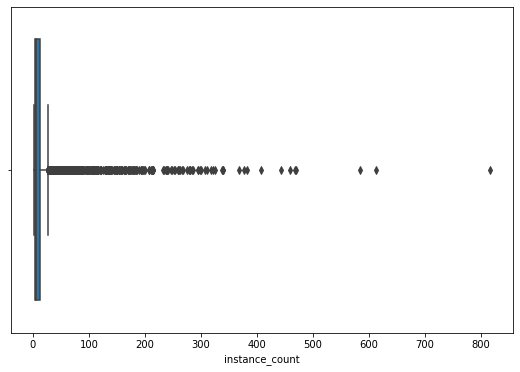

In [13]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.boxplot(data=pat_df, x='instance_count')

plt.show()

Text(0.5, 0, 'Instance Count')

Text(0.5, 0.98, 'Histplot for Patient Image Instances')

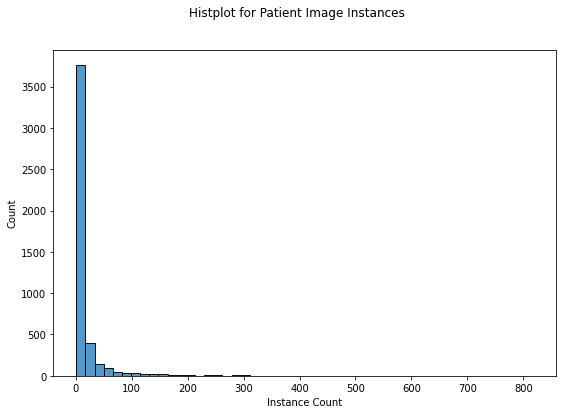

In [14]:
fig, ax = plt.subplots(1, figsize=[9, 6])
ax = sns.histplot(data=pat_df, x='instance_count', bins=50)
ax.set_xlabel('Instance Count')
plt.suptitle('Histplot for Patient Image Instances')
plt.show()

## Report
- 84,484 total instances
- 83,605 unique instances
    - train/CNV contains 37205 files
    - train/DME contains 11348 files
    - train/DRUSEN contains 8616 files
    - train/NORMAL contains 26315 files
    - test/CNV contains 250 files
    - test/DME contains 250 files
    - test/DRUSEN contains 250 files
    - test/NORMAL contains 250 files
- High standard deviation for number of instances per patient

## Get Image size distributions

In [15]:
#test cv2
i = BASE_DATA_PATH+'train/CNV/CNV-1016042-1.jpeg'
img = cv2.imread(i)
dimensions = img.shape
print(dimensions)

(496, 512, 3)


In [16]:
##build filepaths from df

filenames = oct_df.filename.tolist()
paths = oct_df.path.tolist()

file_paths = [] 
for i in range(len(paths)):
    file_paths.append('../data/raw'+paths[i]+'/'+filenames[i])

In [17]:
##get heights, widths, channels of each image - will map back to df
heights = []
widths = []
channels = []
for i in file_paths:
    img = cv2.imread(i)
    dimensions = img.shape
    heights.append(dimensions[0])
    widths.append(dimensions[1])
    channels.append(dimensions[-1])

In [18]:
#reassign img sizes to respective images
oct_df['img_height'] = heights
oct_df['img_width'] = widths
oct_df['num_channels'] = channels

In [19]:
def plot_hist(col,plot_name):
    figsize = (12, 4)
    fig,axs = plt.subplots(1,3, figsize=figsize)

    plt.subplots_adjust(wspace=10)
    oct_df[col].hist(ax=axs[0])
    oct_df.loc[oct_df['type'] == 'train',[col]].hist(ax=axs[1])
    oct_df.loc[oct_df['type'] == 'test',[col]].hist(ax=axs[2])

    plt.suptitle(plot_name)
    axs[0].title.set_text('all data')
    axs[1].title.set_text('train')
    axs[2].title.set_text('test')
    fig.tight_layout();    

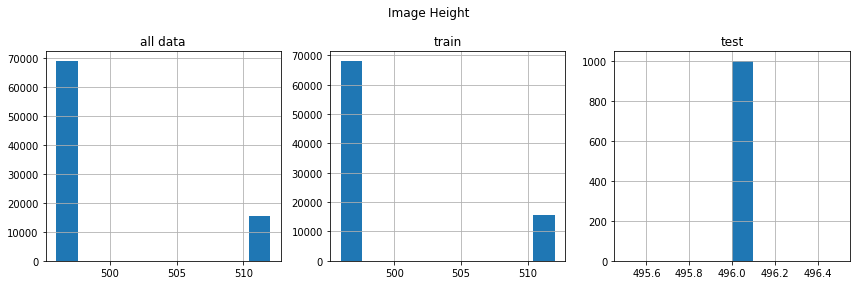

In [20]:
plot_hist('img_height', 'Image Height')

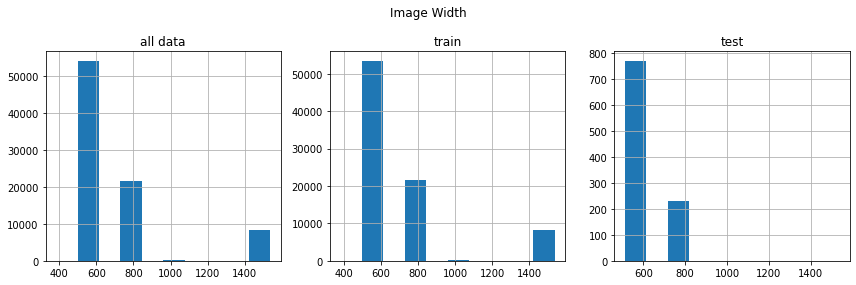

In [21]:
plot_hist('img_width', 'Image Width')

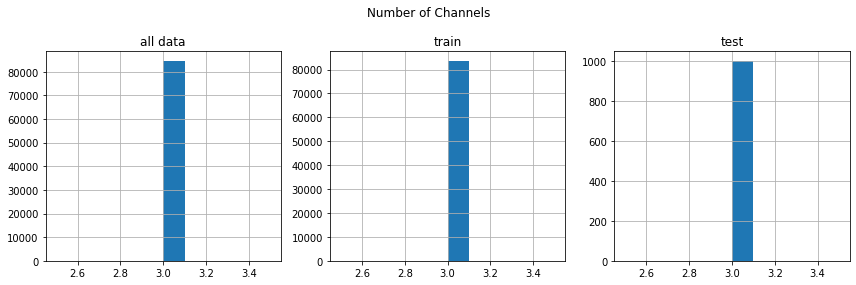

In [22]:
plot_hist('num_channels', 'Number of Channels')

In [23]:
oct_df[['img_width','img_height','num_channels']].describe()

,img_width,img_height,num_channels
count,84484.000000,84484.000000,84484.0
mean,680.788978,498.927134,3.0
std,304.950318,6.185991,0.0
min,384.000000,496.000000,3.0
25%,512.000000,496.000000,3.0
50%,512.000000,496.000000,3.0
75%,768.000000,496.000000,3.0
max,1536.000000,512.000000,3.0


In [24]:
oct_df.loc[oct_df['type'] == 'test', ['img_width','img_height']].describe()

,img_width,img_height
count,1000.000000,1000.0
mean,571.904000,496.0
std,112.008538,0.0
min,512.000000,496.0
25%,512.000000,496.0
50%,512.000000,496.0
75%,512.000000,496.0
max,1536.000000,496.0


In [25]:
img_properties_df_grouped = pd.DataFrame(oct_df.groupby('type', as_index=False)['img_width'].value_counts())
img_properties_df_grouped['perc'] = img_properties_df_grouped['count']/img_properties_df_grouped\
    .groupby('type')['count'].transform(lambda x: x.sum())
img_properties_df_grouped

,type,img_width,count,perc
0,test,512,769,0.769000
1,test,768,230,0.230000
2,test,1536,1,0.001000
3,train,512,53348,0.639021
4,train,768,21485,0.257355
5,train,1536,8361,0.100151
6,train,1024,274,0.003282
7,train,384,16,0.000192


## Take aways from img sizes
1. Good news~ We have 3 channels for everything!
2. For the most part, the images appear to be the same height... at least in the test set
3. We have some pretty real variation in the image widths. 
    - Train folders
        - ~64% have width of 512
        - ~26% have width of 768
        - ~10% have width of 1536
        - less than 1% have widthof 1024 and 384
    - test folders
        - ~77% have width of 512
        - ~23% have width of 768
        - 1 image has width of 1536

The above summary means that we need to normalize the image sizes. 


## Explore 'duplicates'

In [26]:
duplicate_files.reset_index()

,index,filename,path,type,disease,pat_id,img_id,filetype
0,83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg
1,83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg
2,83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg
3,83501,CNV-1016042-4.jpeg,/OCT2017/test/CNV,test,CNV,1016042,4,jpeg
4,83656,CNV-103044-1.jpeg,/OCT2017/test/CNV,test,CNV,103044,1,jpeg
...,...,...,...,...,...,...,...,...
874,84346,NORMAL-84466-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,84466,1,jpeg
875,84429,NORMAL-85367-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,85367,1,jpeg
876,84368,NORMAL-9053621-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9053621,1,jpeg
877,84350,NORMAL-9251-1.jpeg,/OCT2017/test/NORMAL,test,NORMAL,9251,1,jpeg


In [27]:

def get_path(base_path, disease, filename):
    return os.path.join(base_path,disease, filename)

duplicate_files['train_file_path'] = duplicate_files\
    .apply(lambda x: get_path(TRAIN_BASE_PATH, x.disease, x.filename), axis=1)

duplicate_files['test_file_path'] = duplicate_files\
    .apply(lambda x: get_path(TEST_BASE_PATH, x.disease, x.filename), axis=1)

duplicate_files['train_files'] = duplicate_files['train_file_path'].apply(lambda x: cv2.imread(x))
duplicate_files['test_files'] = duplicate_files['test_file_path'].apply(lambda x: cv2.imread(x))


In [28]:
# calculate columns we want to keep
duplicate_files['train_file_shape'] = duplicate_files['train_files'].apply(lambda x: x.shape)
duplicate_files['test_file_shape'] = duplicate_files['test_files'].apply(lambda x: x.shape)
duplicate_files['test_train_equal_shape'] = \
    (duplicate_files['train_file_shape']==duplicate_files['test_file_shape']).astype(int)

def sameness(train_file_shape,test_file_shape,train_files,test_files):
    if train_file_shape!=test_file_shape:
        sameness=np.nan
    else:
        sameness=(train_files==test_files).sum()/(train_file_shape[0]*train_file_shape[1]*train_file_shape[-1])
    return sameness

duplicate_files['sameness_percent'] = duplicate_files \
    .apply(lambda x: sameness(x.train_file_shape, x.test_file_shape, x.train_files, x.test_files), axis=1)

filtered_list = duplicate_files.columns
filtered_list = \
    [i for i in filtered_list if i not in ['train_files', 'test_files', 'train_file_path', 'test_file_path']]

#duplicate_files = duplicate_files[filtered_list]

In [29]:
duplicate_files[filtered_list].head()

,filename,path,type,disease,pat_id,img_id,filetype,train_file_shape,test_file_shape,test_train_equal_shape,sameness_percent
83664,CNV-1016042-1.jpeg,/OCT2017/test/CNV,test,CNV,1016042,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.025241
83551,CNV-1016042-2.jpeg,/OCT2017/test/CNV,test,CNV,1016042,2,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.019244
83601,CNV-1016042-3.jpeg,/OCT2017/test/CNV,test,CNV,1016042,3,jpeg,"(496, 512, 3)","(496, 768, 3)",0,NaN
83501,CNV-1016042-4.jpeg,/OCT2017/test/CNV,test,CNV,1016042,4,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.032644
83656,CNV-103044-1.jpeg,/OCT2017/test/CNV,test,CNV,103044,1,jpeg,"(496, 768, 3)","(496, 512, 3)",0,NaN


In [30]:
duplicate_files[filtered_list].describe()

,test_train_equal_shape,sameness_percent
count,879.000000,302.000000
mean,0.343572,0.115661
std,0.475171,0.267132
min,0.000000,0.003300
25%,0.000000,0.021168
50%,0.000000,0.031498
75%,1.000000,0.048408
max,1.000000,1.000000


In [36]:
mask_notna = duplicate_files['sameness_percent'].notna()
mask_identical = duplicate_files['sameness_percent']==1
mask_diff_shape = duplicate_files['test_train_equal_shape']==0

duplicate_files[mask_identical].shape[0]
duplicate_files[mask_diff_shape].shape[0]
duplicate_files[mask_notna & (~mask_identical)].shape[0]

duplicate_files[mask_notna & (~mask_identical)]['sameness_percent'].describe()

25

577

277

count    277.000000
mean       0.035847
std        0.024324
min        0.003300
25%        0.020283
50%        0.029179
75%        0.042239
max        0.152478
Name: sameness_percent, dtype: float64

### Summary of duplicate:

- Out of 879 duplciates 
    - 577 duplicates with different shapes.
        - we need to preprocess them to the same size to be able to compare them
    - 25 identical duplicates, i.e same shape and values.
        - We can safely remove them from the training set. 
    - 277 duplicates with the same shape, but different values. 
        - The highest similarity for theses duplicates is 15%. 
            
Let's plot some of the duplicates of the last group.

In [43]:
highest_sim = duplicate_files[mask_notna & (~mask_identical)]['sameness_percent'].max()
highest_sim_instance = duplicate_files[duplicate_files['sameness_percent']==highest_sim]
highest_sim_instance[filtered_list]

,filename,path,type,disease,pat_id,img_id,filetype,train_file_shape,test_file_shape,test_train_equal_shape,sameness_percent
83982,DME-7650134-2.jpeg,/OCT2017/test/DME,test,DME,7650134,2,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.152478


In [77]:
def plot_img(train_path, test_path):
    train_img = cv2.imread(train_path)
    test_img = cv2.imread(test_path)
    figsize = (12, 6)
    fig,axs = plt.subplots(1,2, figsize=figsize)
    
    #plt.subplots_adjust(wspace=10)
    axs[0].imshow(train_img, aspect='auto')
    axs[1].imshow(test_img, aspect='auto')
    axs[0].title.set_text('train')
    axs[1].title.set_text('test')

    fig.tight_layout(); 

### plot the duplicates with the highest similarities

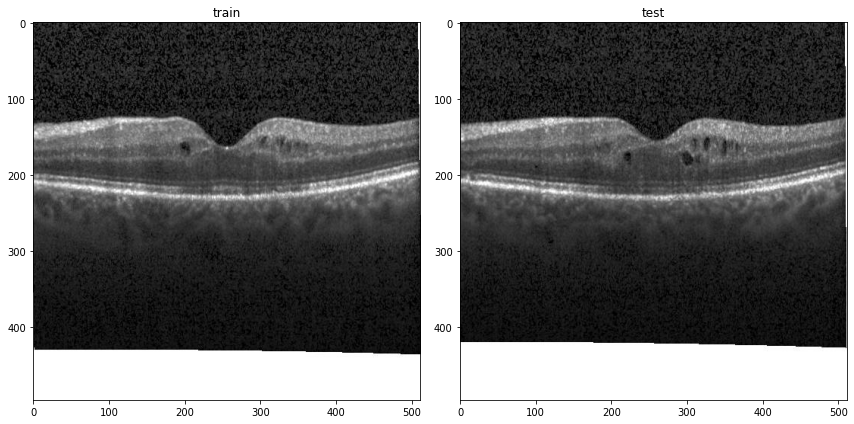

In [91]:
train_path_highest_sim = get_path(TRAIN_BASE_PATH, highest_sim_instance.disease.iloc[0],\
                      highest_sim_instance.filename.iloc[0])
test_path_highest_sim = get_path(TEST_BASE_PATH, highest_sim_instance.disease.iloc[0],\
                      highest_sim_instance.filename.iloc[0])

plot_img(train_path_highest_sim,test_path_highest_sim)

We can observe that that the these 2 images are visually different. 

Let's look at the duplicates with the least similarity. 

,filename,path,type,disease,pat_id,img_id,filetype,train_file_shape,test_file_shape,test_train_equal_shape,sameness_percent
83500,CNV-1699976-3.jpeg,/OCT2017/test/CNV,test,CNV,1699976,3,jpeg,"(496, 512, 3)","(496, 512, 3)",1,0.0033


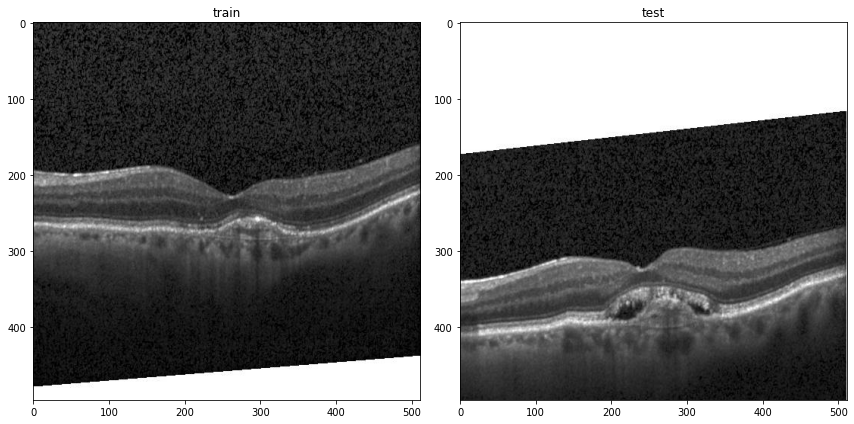

In [92]:
lowest_sim = duplicate_files[mask_notna & (~mask_identical)]['sameness_percent'].min()
lowest_sim_instance = duplicate_files[duplicate_files['sameness_percent']==lowest_sim]
lowest_sim_instance[filtered_list]

train_path_lowest_sim = get_path(TRAIN_BASE_PATH, lowest_sim_instance.disease.iloc[0],\
                      lowest_sim_instance.filename.iloc[0])
test_path_lowest_sim = get_path(TEST_BASE_PATH, lowest_sim_instance.disease.iloc[0],\
                      lowest_sim_instance.filename.iloc[0])

plot_img(train_path_lowest_sim,test_path_lowest_sim)

Let's see how many images in both train/test belongs to this patient. 

In [93]:
train_path_lowest_sim

'../data/raw/OCT2017/train/CNV/CNV-1699976-3.jpeg'

In [96]:
oct_df[oct_df.filename.str.contains('1699976')].shape
oct_df[oct_df.filename.str.contains('1699976')]

(444, 10)

,filename,path,type,disease,pat_id,img_id,filetype,img_height,img_width,num_channels
42,CNV-1699976-72.jpeg,/OCT2017/train/CNV,train,CNV,1699976,72,jpeg,496,768,3
43,CNV-1699976-321.jpeg,/OCT2017/train/CNV,train,CNV,1699976,321,jpeg,496,512,3
70,CNV-1699976-264.jpeg,/OCT2017/train/CNV,train,CNV,1699976,264,jpeg,496,768,3
308,CNV-1699976-376.jpeg,/OCT2017/train/CNV,train,CNV,1699976,376,jpeg,496,768,3
309,CNV-1699976-25.jpeg,/OCT2017/train/CNV,train,CNV,1699976,25,jpeg,496,768,3
...,...,...,...,...,...,...,...,...,...,...
83500,CNV-1699976-3.jpeg,/OCT2017/test/CNV,test,CNV,1699976,3,jpeg,496,512,3
83519,CNV-1699976-2.jpeg,/OCT2017/test/CNV,test,CNV,1699976,2,jpeg,496,512,3
83546,CNV-1699976-5.jpeg,/OCT2017/test/CNV,test,CNV,1699976,5,jpeg,496,512,3
83602,CNV-1699976-4.jpeg,/OCT2017/test/CNV,test,CNV,1699976,4,jpeg,496,512,3


Let's see how many images in both train/test belongs to the patient with highest similarity in duplicates. 

In [97]:
train_path_highest_sim

'../data/raw/OCT2017/train/DME/DME-7650134-2.jpeg'

In [99]:
oct_df[oct_df.filename.str.contains('7650134')].shape
oct_df[oct_df.filename.str.contains('7650134')]

(21, 10)

,filename,path,type,disease,pat_id,img_id,filetype,img_height,img_width,num_channels
37892,DME-7650134-1.jpeg,/OCT2017/train/DME,train,DME,7650134,1,jpeg,496,512,3
43634,DME-7650134-5.jpeg,/OCT2017/train/DME,train,DME,7650134,5,jpeg,496,1536,3
45041,DME-7650134-4.jpeg,/OCT2017/train/DME,train,DME,7650134,4,jpeg,496,1536,3
45790,DME-7650134-3.jpeg,/OCT2017/train/DME,train,DME,7650134,3,jpeg,496,512,3
48534,DME-7650134-2.jpeg,/OCT2017/train/DME,train,DME,7650134,2,jpeg,496,512,3
49836,DRUSEN-7650134-2.jpeg,/OCT2017/train/DRUSEN,train,DRUSEN,7650134,2,jpeg,496,512,3
55729,DRUSEN-7650134-1.jpeg,/OCT2017/train/DRUSEN,train,DRUSEN,7650134,1,jpeg,496,512,3
58188,NORMAL-7650134-11.jpeg,/OCT2017/train/NORMAL,train,NORMAL,7650134,11,jpeg,496,1536,3
60022,NORMAL-7650134-2.jpeg,/OCT2017/train/NORMAL,train,NORMAL,7650134,2,jpeg,496,512,3
60919,NORMAL-7650134-3.jpeg,/OCT2017/train/NORMAL,train,NORMAL,7650134,3,jpeg,496,1536,3


## Takeaway from duplicates images

- The images do not have straight borders. 
- Some images have lower and some, upper border which is blank. 
- There is a patient with 444 images. 
- There is a patient that belongs to 3 diseases. 


We have to think about the best way to standardize them to avoid losing information. 

<span style="color:red">**Question**</span>: 
 Given that a patient ID appears 444 times and another patient ID belongs to 3 diseases, do we assume that these patient IDs come from different clinics and they are not necessarily the same patient? Or is it medically possible for a patient to have 3 of the diseases?

For now, it is safe to remove the 25 identical duplicates. 

In [115]:
duplicate_files[mask_identical][filtered_list].head()
identical_duplicate_filenames = duplicate_files[mask_identical]['filename']
'instances b4 removing duplicates', len(oct_df)
oct_df = oct_df[(~oct_df['filename'].isin(identical_duplicate_filenames.tolist())) & (oct_df['type']=='train')]
'instances after removing duplicates', len(oct_df)

,filename,path,type,disease,pat_id,img_id,filetype,train_file_shape,test_file_shape,test_train_equal_shape,sameness_percent
83700,CNV-1784116-1.jpeg,/OCT2017/test/CNV,test,CNV,1784116,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
83554,CNV-1997439-1.jpeg,/OCT2017/test/CNV,test,CNV,1997439,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
83673,CNV-3119854-1.jpeg,/OCT2017/test/CNV,test,CNV,3119854,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
83757,DME-7650134-1.jpeg,/OCT2017/test/DME,test,DME,7650134,1,jpeg,"(496, 512, 3)","(496, 512, 3)",1,1.0
83771,DME-7983936-1.jpeg,/OCT2017/test/DME,test,DME,7983936,1,jpeg,"(496, 768, 3)","(496, 768, 3)",1,1.0


('instances b4 removing duplicates', 84484)

('instances after removing duplicates', 83459)

In [123]:
duplicate_files_path = '../data/processed/identical_duplicates.csv'
identical_duplicate_filenames.reset_index(drop=True).to_csv(duplicate_files_path)


When we read in the files in other notebooks, we need to load the above list and remove the duplicates from train. 